# Notebook of the project of Physics of Complex Systems #
Implementation of this [article](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.85.031911).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
import os
import concurrent.futures

import aux      # it's a file with some generic auxiliary functions I often use

## Functions

In [ ]:
def system(z:np.ndarray ,t:np.ndarray ,par:dict):
    """ODEs system for the ISP problem.

    Args:
        z (np.ndarray): _description_
        t (np.ndarray): _description_
        par (dict): _description_

    Returns:
        _type_: _description_
    """
    x, y = z
    dxdt = par['alpha']*x - par['gamma']*x*y
    dydt = par['lambda'] + par['nu']*x*y - par['sigma']*y
    if x < 0:
        x = 0.
    if y < 0:
        y = 0.
    return [dxdt,dydt]

def lattice1(time_steps:int,par:dict,N:int=100,rng=None):
    """
    Vectorized stochastic lattice (no diffusion). Uses a numpy Generator for faster poisson draws.
    """
    if rng is None:
        rng = np.random.default_rng()
    alpha = par['alpha']        # pre-extract parameters (avoid repeated dict lookups)
    gamma = par['gamma']
    lam = par['lambda']
    nu = par['nu']
    sigma = par['sigma']
    lattice = np.zeros((N, 2), dtype=np.int64)      # integer lattice for counts
    lattice[:, 0] = 3
    lattice[:, 1] = 1
    lattice_prev = lattice.copy()
    X_stoc = np.zeros(time_steps, dtype=float)
    Y_stoc = np.zeros(time_steps, dtype=float)
    for t in range(time_steps):
        prod = lattice_prev[:, 0] * lattice_prev[:, 1]            # elementwise xy
        # vectorized Poisson draws
        births_x = rng.poisson(alpha * lattice_prev[:, 0])
        kills_x = rng.poisson(gamma * prod)
        births_y = rng.poisson(lam, size=N)
        dup_y = rng.poisson(nu * prod)
        deaths_y = rng.poisson(sigma * lattice_prev[:, 1])
        # update lattice (vectorized)
        lattice[:, 0] = births_x - kills_x
        lattice[:, 1] = births_y + dup_y - deaths_y
        np.maximum(lattice, 0, out=lattice)         # clip negatives in-place (no negative populations)
        lattice_prev = lattice.copy()           # prepare for next step (must copy to avoid aliasing)
        # mean
        X_stoc[t] = lattice[:, 0].mean()
        Y_stoc[t] = lattice[:, 1].mean()
    return X_stoc, Y_stoc

# Utility functions
def stability(par):         # In which regime are we?
    print(f'In which regime are we? {'First regime:(0,y_0) unstable, (x*,y*) stable' \
        if par['alpha']*par['sigma']>(par['lambda']*par['gamma']) else 'Second regime:(0,y_0) stable, (x*,y*) non-biological'}')
    if par['alpha']*par['sigma']>(par['lambda']*par['gamma']):
        if par['lambda']**2 * par['gamma']**2 > 4*par['alpha']**2 * (par['sigma']*par['alpha']-par['lambda']*par['gamma']):
            print('The attractor (x*,y*) is a stable node (positive disciminant -> no oscillations)') 
        elif par['lambda']**2 * par['gamma']**2 == 4*par['alpha']**2 * (par['sigma']*par['alpha']-par['lambda']*par['gamma']):
            print('The attractor (x*,y*) is a degenerate node (null discriminant)')
        else:
            print(f'The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)')
            
def check_sign(arr:np.ndarray):
    arr[arr<0] = 0.

def add_par_box(par):       # function to add a parameter box to the 
    # Add a parameter box to the plot
    textstr = '\n'.join((
    r'$\alpha=%.2f$' % (par['alpha'], ),
    r'$\gamma=%.2f$' % (par['gamma'], ),
    r'$\lambda=%.2f$' % (par['lambda'], ),
    r'$\nu=%.2e$' % (par['nu'], ),
    r'$\sigma=%.2f$' % (par['sigma'], )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.3)

    # place a text box in the best spot in axes coords
    plt.gca().text(0.98, 0.60, textstr, transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
# Evaluating probability of disappearance
def _run_model_check(args):
    model, N, time_steps, par = args
    X_stoc, _ = model(N=N, time_steps=time_steps, par=par)
    return 1 if X_stoc[-1] == 0 else 0

def P_diss(model, num_nu:int, n_iter:int, N:int, time_steps:int, par:dict):
    """Evaluate statistically the probability of disappearance at the first pass near-zero.

    This optimized version:
    - minimizes dict lookups by using locals,
    - computes distances vectorized,
    - parallelizes independent stochastic realizations using ProcessPoolExecutor.
    """
    # copy base parameters to avoid mutating caller dict
    base_par = par.copy()
    alpha = base_par['alpha']
    gamma = base_par['gamma']
    lam = base_par['lambda']
    sigma = base_par['sigma']
    # nu sweep (reverse so distance ~ 1/nu is monotone)
    nu_values = np.linspace(1e-5, 1.5e-3, num_nu)[::-1]
    # Precompute distances between fixed points (vectorized)
    y_star_local = alpha / gamma            # x* = (sigma - lambda*gamma/alpha)/nu ; y* = alpha/gamma
    P_d = np.zeros((num_nu, 2), dtype=float)
    P_d[:,0] = np.linalg.norm(
        np.stack([np.zeros_like(nu_values),
                  np.full_like(nu_values, lam / sigma)]).T
        - np.stack([(sigma - lam * gamma / alpha) / nu_values,
                    np.full_like(nu_values, y_star_local)]).T,
        axis=1
    )
    # prepare parallel executor size (limit to avoid oversubscription)
    max_workers = min(os.cpu_count() or 1, n_iter, 8)    # 8 is an hard cap on the number of workes to avoid overwhelming the system. os.cpu_count() or 1 to avoid errors if cpu_count returns None, which can happen
    for i, nu in enumerate(nu_values):
        print(f'Distance #{i+1}...')
        par_local = base_par.copy()
        par_local['nu'] = nu            # use a fresh copy for this nu
        # build args for each independent run
        args = [(model, N, time_steps, par_local) for _ in range(n_iter)]
        # run in parallel and sum successes
        success = 0
        if n_iter == 1:
            success = _run_model_check(args[0])     # avoid executor overhead for single run
        else:
            with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as exe:
                for res in exe.map(_run_model_check, args):
                    success += res
        P_d[i,1] = success / n_iter

    return P_d

In [3]:
# set the seed
np.random.seed(12345)
# I set some parameters for the whole project
time_steps = 5000    # 1000
# Set the time grid for the ODEs
t_s = np.linspace(0,time_steps,time_steps)
# parameters initialization (I use the parameters listed in the caption of Figure 3)
par = {
    'alpha': 1.2,   # 1.2
    'gamma': 0.01,   # questo sarebbe 0.01
    'lambda': 0.6,
    'nu': 0.001,
    'sigma': 0.01,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}
# Define some meaningful quantities for the analysis
y0 = par['lambda']/par['sigma']
#y0 = 4 # from Figure 1
y_star = par['alpha']/par['gamma']
x_star = (par['sigma']-par['lambda']*par['gamma']/par['alpha'])/par['nu']
stability(par)

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


Firstly, I try to reproduce the mean-field approach. The resulting system of ODEs is the following:
$$
    \frac{\partial x}{\partial t} = \alpha x - \gamma xy , \;\;\;
    \frac{\partial y}{\partial t} = \lambda + \nu xy - \sigma y
$$
where $x$ is the pathogen concentration and $y$ the lymphocytes'. \
The parameters represent:
- $\alpha$ : proliferation rate of the pathogen; 
- $\gamma$ : destruction rate of the pathogen by the lymphocytes; 
- $\lambda$ : birth rate of the lymphocyte; 
- $\nu$ : duplication rate of the lymphocyte when encountering the pathogen; 
- $\sigma$ : death rate of the lymphocyte. 
## Mean Field Approach ##

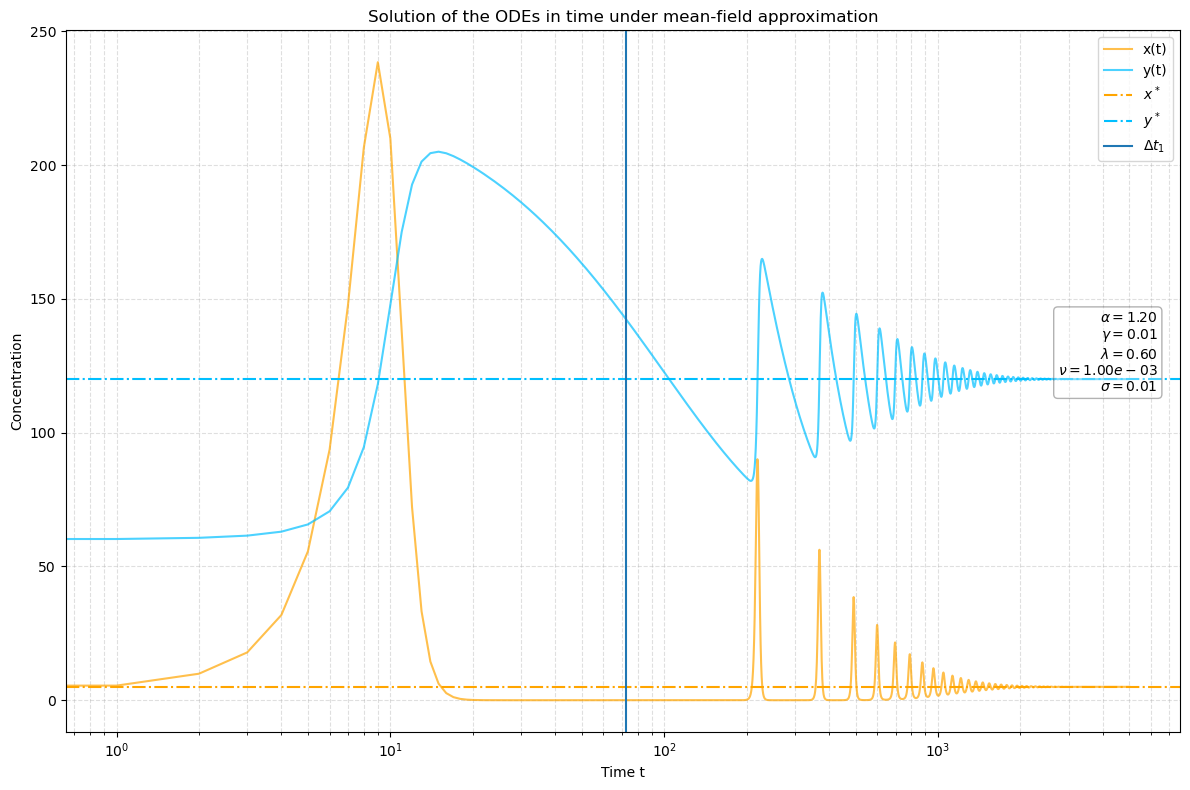

<Figure size 640x480 with 0 Axes>

In [4]:
# set initial conditions
#z0 = np.array([3,np.random.poisson(lam=1)])    # z=[x,y]
#z0 = np.array([x_star,y_star])    # z=[x*,y*] (I try to initialize at a fixed point to verify stability)
z0 = np.array([3,y0])

# Solve
X_ode = odeint(system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(system,z0,t_s,args=(par,))[:,1]

'''
# Normalization
X_ode /= np.max(X_ode)
Y_ode /= np.max(Y_ode)
'''
y_tilde = Y_ode[np.argmin(np.abs(X_ode-1))]
Dt1 = (1/par['gamma'])*(np.log((y_tilde-
                                par['gamma']/par['sigma'])/
                               (par['alpha']/par['gamma']-
                               par['lambda']/par['sigma'])))

# Solution of the X ODE
plt.figure(figsize=(12,8))
plt.plot(t_s, X_ode, c='orange', label='x(t)',alpha=0.7)
plt.plot(t_s, Y_ode, c='deepskyblue', label='y(t)',alpha=0.7)
plt.title('Solution of the ODEs in time under mean-field approximation')
plt.axhline(y=x_star,label=r'$x^*$',c='orange',linestyle='-.')
plt.axhline(y=y_star,label=r'$y^*$',c='deepskyblue',linestyle='-.')
plt.axvline(Dt1,label=r'$\Delta t_1$')
plt.xlabel('Time t')
plt.ylabel('Concentration')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
add_par_box(par)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.savefig('plots/ODE.png')

The time it takes for $y$ to reach $\tilde{y}$, which is the value of $y$ for which $x=1$, is approximately:
$$
\Delta t_1 = \frac{1}{\gamma}\ln\left(\frac{\tilde{y}-\frac{\lambda}{\sigma}}{\frac{\alpha}{\gamma}-\frac{\lambda}{\sigma}}\right)
$$
while, the time it takes for $x$ to increase from 1 to a larger number $k$ is:
$$
\Delta t_2 = \frac{1}{\alpha}\ln k
$$
Now I recreate the trajectory of the solutions of the ODE

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


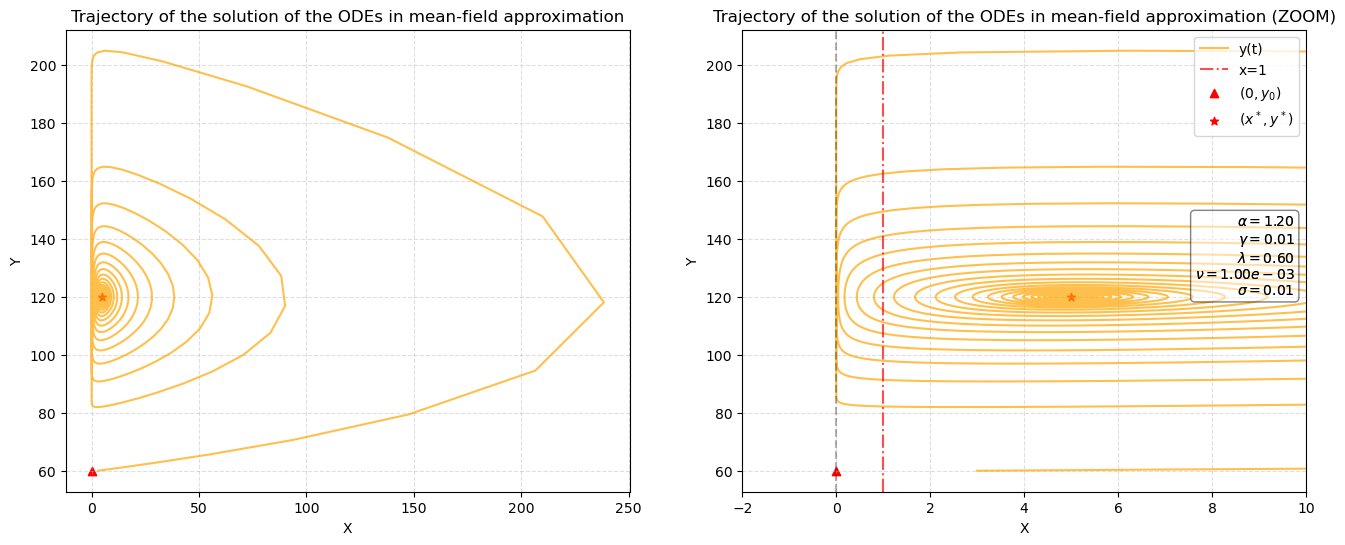

In [5]:
stability(par)

fig,ax = plt.subplots(1,2,figsize=(16,6))
# Trajectory of the solutions over time
ax[0].plot(X_ode, Y_ode, c='orange', label='y(t)',alpha=0.7)
ax[0].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
ax[0].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[0].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].grid(True, which="both",alpha=0.4,linestyle='--')
add_par_box(par)

# Trajectory of the solutions over time zoomed
ax[1].plot(X_ode, Y_ode, c='orange', label='y(t)',alpha=0.7)
ax[1].axvline(1,c='r',linestyle='-.',label='x=1',alpha=0.7)
ax[1].axvline(0,c='black',linestyle='--',alpha=0.3)
ax[1].set_title('Trajectory of the solution of the ODEs in mean-field approximation (ZOOM)')
ax[1].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[1].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1].set_xlim(-2,10)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].grid(True, which="both",alpha=0.4,linestyle='--')
add_par_box(par)
plt.legend(loc='upper right')
plt.savefig('plots/Traj_ODE.png')

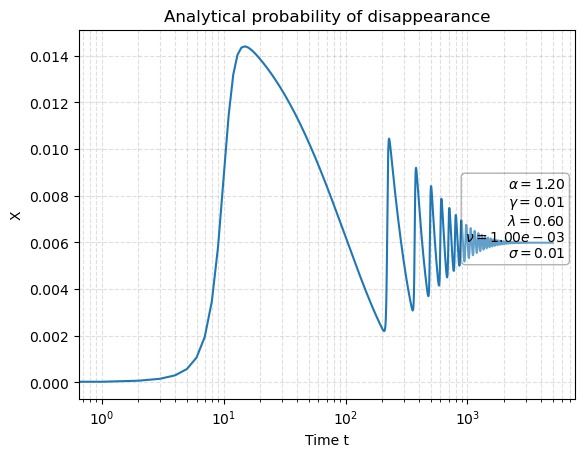

In [6]:
def P_da(x,y,par,y0):
    # this I've obtained from the expression for the disappearance probability at page 4 (see paper notes)
    #return 1-np.exp(-par['gamma']*(par['lambda']+y*(par['nu']*x-par['sigma'])-par['sigma']*y0))
    return 1-np.exp(-par['gamma']*par['sigma']*(y-y0))      # here, as suggested in page 3, I ignore the term $\nu xy$ in y', since x is small.
    #return par['gamma']*y
    
#plt.plot(P_da(X_ode,Y_ode,par,y0)/np.max(P_da(X_ode,Y_ode,par,y0)))
plt.plot(P_da(X_ode,Y_ode,par,y0))
plt.title('Analytical probability of disappearance')
plt.xlabel('Time t')
plt.ylabel('X')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
# Create a box plot for the parameters in 'par'
add_par_box(par)

## Lattice ##
The interactions between pathogens and lymphocytes are described by the following reactions:
$$
\begin{gather}
    X \xrightarrow{\alpha} X + X \\
    \emptyset \xrightarrow{\lambda} Y \\
    X + Y \xrightarrow{\gamma} Y  \\
    X + Y \xrightarrow{\nu} X + 2Y \\
    Y \xrightarrow{\sigma} \emptyset .
\end{gather}
$$
### 1D ##
Firstly, I try a toy model of a 1D lattice with 100 cells and no diffusion (mean-field approximation):

In [7]:
par['alpha'] = 1.6
par['nu'] = 0.001
par

{'alpha': 1.6,
 'gamma': 0.01,
 'lambda': 0.6,
 'nu': 0.001,
 'sigma': 0.01,
 'Dx': 0.0,
 'Dy': 0.0}

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


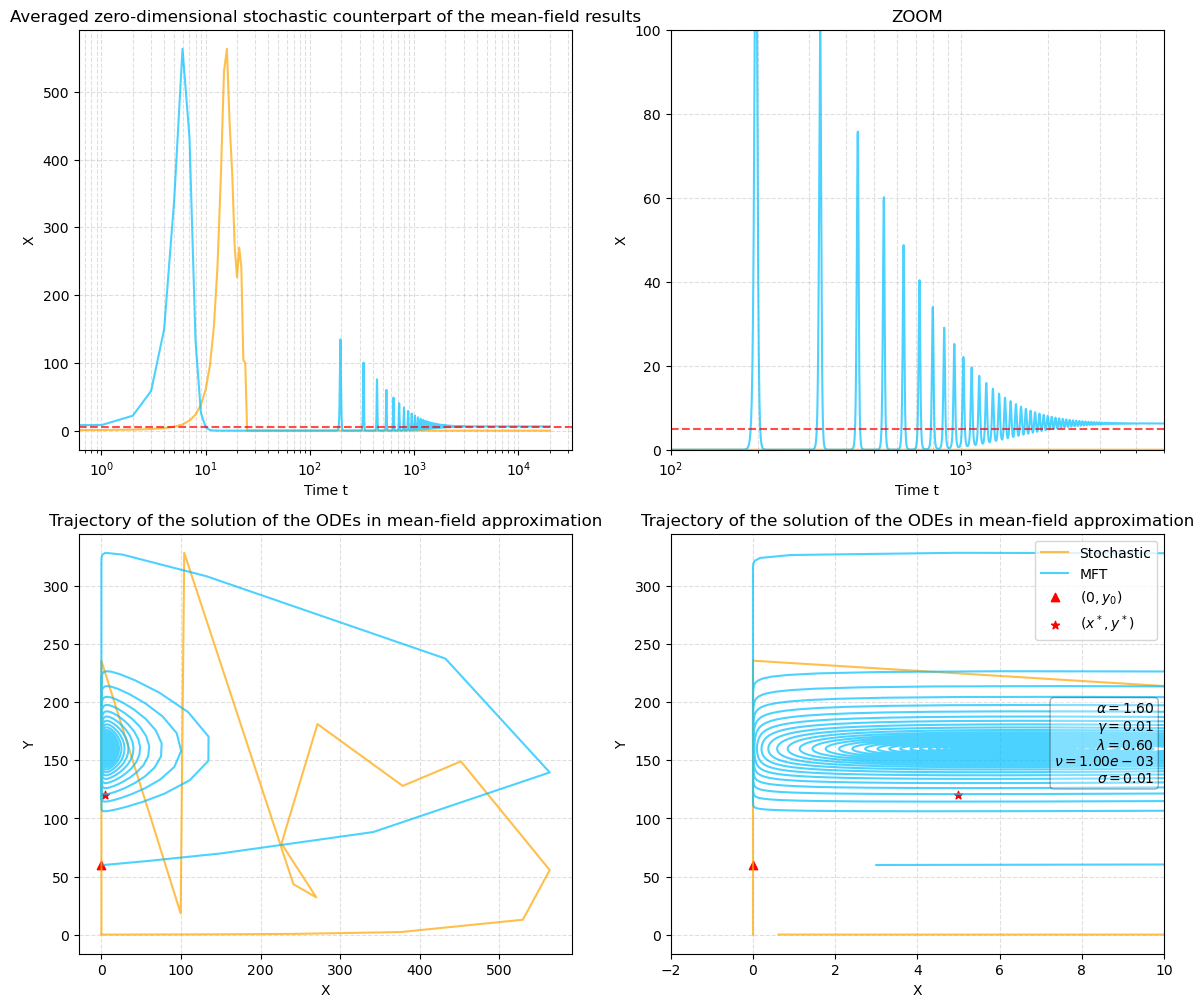

In [8]:
stability(par)
# I set some parameters for the whole project
time_steps = 20000    # 1000
# Set the time grid for the ODEs
t_s = np.linspace(0,time_steps,time_steps)
# set initial conditions
z0 = np.array([3,y0])
# Solve again the ODEs so to have it with the right parameters, in case that they're different for the stochastic case
X_ode = odeint(system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(system,z0,t_s,args=(par,))[:,1]

# Compute the model
X_stoc, Y_stoc = lattice1(N=100,time_steps=time_steps,par=par)

scalex = np.max(X_stoc)/np.max(X_ode)
scaley = np.max(Y_stoc)/np.max(Y_ode)
fig, ax = plt.subplots(2,2,figsize=(14,12))
# plot the evolution of x(t)
ax[0,0].plot(X_stoc/scalex,c='orange',label='x(t)-Stochastic',alpha=0.7)
ax[0,0].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)          # multiplied by 4 only for scaling
ax[0,0].axhline(x_star,c='r',linestyle='--',label=r'$x^*$',alpha=0.7)
ax[0,0].set_title('Averaged zero-dimensional stochastic counterpart of the mean-field results')
ax[0,0].set_xlabel('Time t')
ax[0,0].set_ylabel('X')
ax[0,0].set_xscale('log')
ax[0,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[0,1].plot(X_stoc/scalex,c='orange',label='x(t)-Stochastic',alpha=0.7)
ax[0,1].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)
ax[0,1].axhline(x_star,c='r',linestyle='--',label=r'$x^*$',alpha=0.7)
ax[0,1].set_title('ZOOM')
ax[0,1].set_xlim(100,5000)
ax[0,1].set_ylim(0,100)
ax[0,1].set_xlabel('Time t')
ax[0,1].set_ylabel('X')
ax[0,1].set_xscale('log')
ax[0,1].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,0].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label='Stochastic',alpha=0.7)
ax[1,0].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,0].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
ax[1,0].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[1,0].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Y')
ax[1,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,1].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label='Stochastic',alpha=0.7)
ax[1,1].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,1].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
ax[1,1].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[1,1].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,1].set_xlim(-2,10)
ax[1,1].set_xlabel('X')
ax[1,1].set_ylabel('Y')
ax[1,1].grid(True, which="both",alpha=0.4,linestyle='--')
add_par_box(par)
plt.legend(loc='upper right')
plt.show()

Now I study the disappearance probability at the first pass near zero as a function of the distance between the two stable points.\
I only check for having zero pathogen for the zero-pathogen absorbing state; for now I don't care about Y.

I try to use as the first pass near-zero the moment for whihc $y\sim \alpha / \gamma$. In the paper, this is said to happen after a time $\Delta t_1$:
$$
\Delta t_1 = \frac{1}{\sigma}\ln\left[\frac{(\tilde{y} - \frac{\lambda}{\sigma})}{
(\frac{\alpha}{\gamma}-\frac{\lambda}{\sigma})}\right]
$$
where $\tilde{y}$ is the value of $y$ for which $x=1$.\
Such value, we can either extract it analitically from the ODEs or we can retrieve it through simulations. \
As a first approach, we will do the former.

In [9]:
par['alpha'] = 1.2
par['gamma'] = 0.1
par['lambda'] = 0.4
par['sigma'] = 0.1
par

{'alpha': 1.2,
 'gamma': 0.1,
 'lambda': 0.4,
 'nu': 0.001,
 'sigma': 0.1,
 'Dx': 0.0,
 'Dy': 0.0}

In [12]:
P_diss = P_diss(lattice1,num_nu=100,n_iter=50,N=10000,time_steps=400,par=par)

plt.figure(figsize=(12,8))
plt.plot(P_diss,c='orange')
plt.xscale('log')
plt.title('Probability of disappearance vs distance between the fixed points')
plt.xlabel('Distance between fixed points')
plt.ylabel('Probability of disappearance')
plt.grid(True, which='both',alpha=0.7)
plt.show()

TypeError: P_diss() got an unexpected keyword argument 'par'

In [ ]:
def DP1d(N:int=10000,timesteps:int=500,Pdis:float=0,Pinv:float=0,rng=None):
    if rng is None:
        rng = np.random.default_rng
    lattice = np.ones(N)    # initialize the lattice with all 1s
    lattice_old = lattice.copy()
    for _ in range(timesteps):
        Mdis = rng.choice(2,(N,),p=np.array([Pdis,1-Pdis]))
        Minv = rng.choice(2,(N,),p=np.array([Pinv,1-Pinv]))
        # disappearance step
        lattice *= Mdis
        lattice = CLIPPATO A 1 E 0(lattice_old * Minv_SHIFTATO_A_DX + lattice_old * Minv_SHIFTATO_A_SX)